
# Serology Overall Accuracy Driver
This notebook builds an end-to-end modeling pipeline to explain **overall serology kit accuracy** using your dataset.

**Target:** `antibody_agree` mapped to 1 for TP/TN and 0 for FP/FN.  
**Features:** numeric (`days_from_symptom`, `igg_titer`, `igm_titer`, `pan_titer`) and categorical (`type`, `group`, `manufacturer`, `device`).  
**Models:** Logistic Regression (interpretable) and Random Forest (nonlinear baseline).  
**Outputs:** ROC, PR, calibration curves; top logistic coefficients; random forest importances; metrics table.


In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score,
                             confusion_matrix, classification_report)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

DATA_PATH = Path("/mnt/data/covid19serology.csv")  
OUT_DIR = Path("./overall_accuracy_driver_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


## Load data and define target/feature sets

In [2]:

df = pd.read_csv(r"C:\Users\rbodh\Downloads\CSE 6242\Project\Data\covid19serology.csv")

# Target: 1 for correct (TP/TN), 0 for incorrect (FP/FN)
agree = df["antibody_agree"].astype(str).str.lower().str.strip()
y = agree.map({"tp":1, "tn":1, "fp":0, "fn":0})

# Feature sets
num_features = [c for c in ["days_from_symptom","igg_titer","igm_titer","pan_titer"] if c in df.columns]
cat_features = [c for c in ["type","group","manufacturer","device"] if c in df.columns]

X = df[num_features + cat_features].copy()
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].astype(int).reset_index(drop=True)

print("Rows used:", len(y))
print("Numeric features:", num_features)
print("Categorical features:", cat_features)
y.value_counts(normalize=True).rename({0:"incorrect", 1:"correct"})


Rows used: 13415
Numeric features: ['days_from_symptom', 'igg_titer', 'igm_titer', 'pan_titer']
Categorical features: ['type', 'group', 'manufacturer', 'device']


antibody_agree
correct      0.935147
incorrect    0.064853
Name: proportion, dtype: float64

## Preprocess: impute + log1p numeric, impute + one-hot categorical

In [4]:

num_transform = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(lambda a: np.log1p(np.clip(a, a_min=0, a_max=None)), feature_names_out="one-to-one"))
])
cat_transform = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
])

pre = ColumnTransformer([
    ("num", num_transform, num_features),
    ("cat", cat_transform, cat_features),
], remainder="drop")


## Train/test split and model definitions

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logit = LogisticRegression(max_iter=500, class_weight="balanced", solver="lbfgs")
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, n_jobs=-1, class_weight="balanced_subsample", random_state=42
)

logit_pipe = Pipeline([("pre", pre), ("clf", logit)])
rf_pipe    = Pipeline([("pre", pre), ("clf", rf)])

logit_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
print("Fitted both models.")


Fitted both models.


## Holdout evaluation

In [6]:

def evaluate(pipe, X_te, y_te):
    try:
        y_score = pipe.predict_proba(X_te)[:,1]
    except Exception:
        y_score = pipe.decision_function(X_te)
    fpr, tpr, _ = roc_curve(y_te, y_score)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_te, y_score)
    ap = average_precision_score(y_te, y_score)
    y_pred = pipe.predict(X_te)
    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    return (fpr, tpr, roc_auc, precision, recall, ap, cm, report, y_score)

l_fpr, l_tpr, l_auc, l_prec, l_rec, l_ap, l_cm, l_report, l_score = evaluate(logit_pipe, X_test, y_test)
r_fpr, r_tpr, r_auc, r_prec, r_rec, r_ap, r_cm, r_report, r_score = evaluate(rf_pipe, X_test, y_test)

summary_rows = [
    {"model":"Logistic Regression", "roc_auc_holdout": l_auc, "avg_precision_holdout": l_ap,
     "precision_0": l_report.get("0",{}).get("precision", np.nan),
     "recall_0":    l_report.get("0",{}).get("recall", np.nan),
     "f1_0":        l_report.get("0",{}).get("f1-score", np.nan),
     "precision_1": l_report.get("1",{}).get("precision", np.nan),
     "recall_1":    l_report.get("1",{}).get("recall", np.nan),
     "f1_1":        l_report.get("1",{}).get("f1-score", np.nan)},
    {"model":"Random Forest", "roc_auc_holdout": r_auc, "avg_precision_holdout": r_ap,
     "precision_0": r_report.get("0",{}).get("precision", np.nan),
     "recall_0":    r_report.get("0",{}).get("recall", np.nan),
     "f1_0":        r_report.get("0",{}).get("f1-score", np.nan),
     "precision_1": r_report.get("1",{}).get("precision", np.nan),
     "recall_1":    r_report.get("1",{}).get("recall", np.nan),
     "f1_1":        r_report.get("1",{}).get("f1-score", np.nan)},
]
summary_df = pd.DataFrame(summary_rows).round(3)
display(summary_df)

summary_df.to_csv(OUT_DIR / "holdout_metrics.csv", index=False)


,model,roc_auc_holdout,avg_precision_holdout,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
0,Logistic Regression,0.833,0.985,0.187,0.730,0.297,0.977,0.780,0.867
1,Random Forest,0.816,0.982,0.223,0.483,0.305,0.961,0.884,0.921


## ROC curve

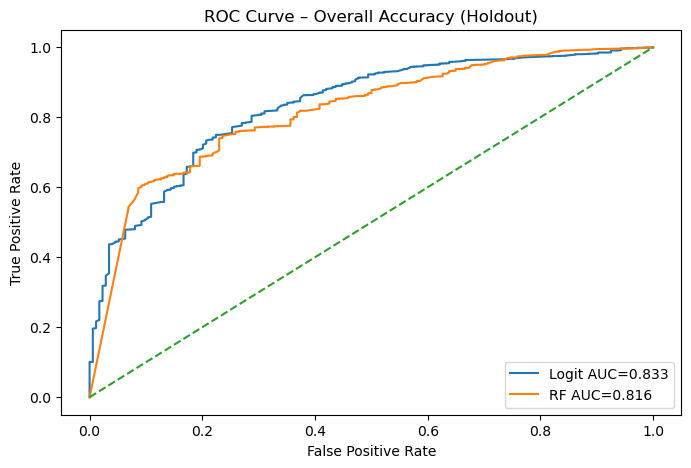

In [7]:

plt.figure(figsize=(8,5))
plt.plot(l_fpr, l_tpr, label=f'Logit AUC={l_auc:.3f}')
plt.plot(r_fpr, r_tpr, label=f'RF AUC={r_auc:.3f}')
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Overall Accuracy (Holdout)")
plt.legend(loc="lower right")
plt.savefig(OUT_DIR / "roc_curve.png", bbox_inches="tight")
plt.show()


## Precision–Recall curve

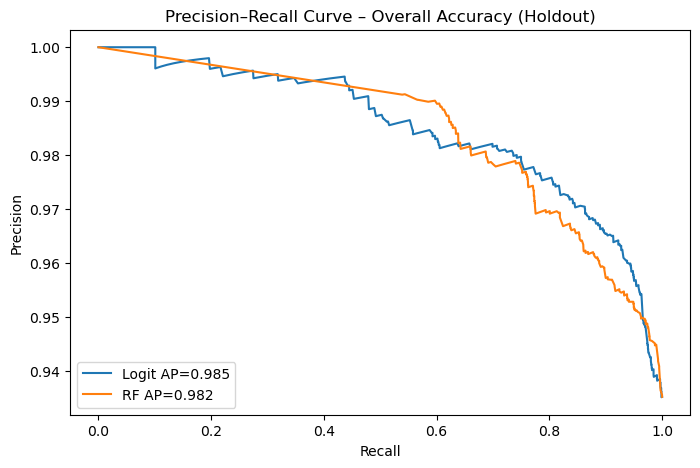

In [8]:

plt.figure(figsize=(8,5))
plt.plot(l_rec, l_prec, label=f'Logit AP={l_ap:.3f}')
plt.plot(r_rec, r_prec, label=f'RF AP={r_ap:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Overall Accuracy (Holdout)")
plt.legend(loc="lower left")
plt.savefig(OUT_DIR / "pr_curve.png", bbox_inches="tight")
plt.show()


## Calibration curve (Logistic Regression)

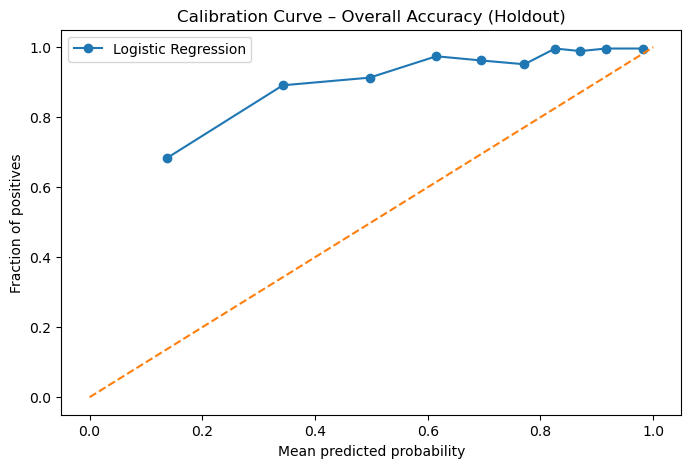

In [9]:

frac_pos, mean_pred = calibration_curve(y_test, l_score, n_bins=10, strategy="quantile")
plt.figure(figsize=(8,5))
plt.plot(mean_pred, frac_pos, marker="o", label="Logistic Regression")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve – Overall Accuracy (Holdout)")
plt.legend()
plt.savefig(OUT_DIR / "calibration_curve.png", bbox_inches="tight")
plt.show()


## Logistic regression coefficients (top 20 absolute)

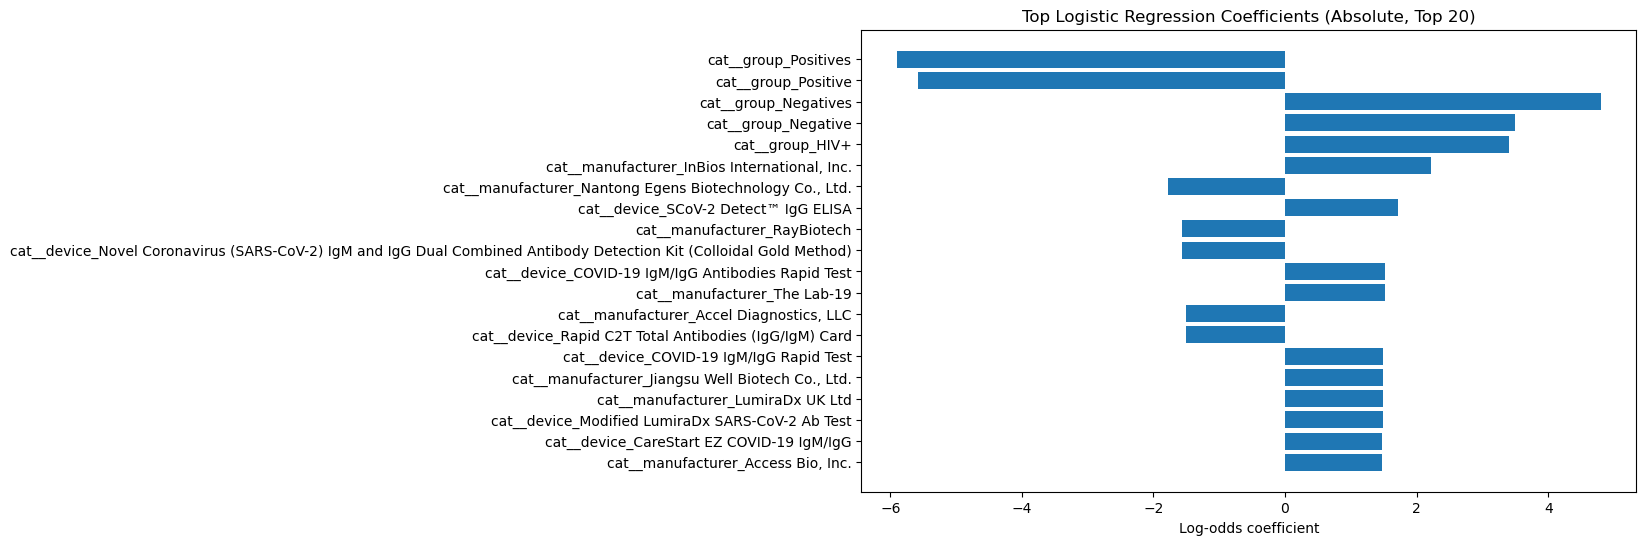

In [10]:

# Ensure preprocessor is fitted
logit_pipe.named_steps["pre"].fit(X_train)
try:
    feat_names = logit_pipe.named_steps["pre"].get_feature_names_out()
except Exception:
    num_names = num_features
    cat_ohe = logit_pipe.named_steps["pre"].transformers_[1][1].named_steps["onehot"]
    cat_names = []
    for i, c in enumerate(cat_features):
        try:
            cats = list(cat_ohe.categories_[i])
        except Exception:
            cats = []
        cat_names += [f"{c}__{v}" for v in cats]
    feat_names = np.array(num_names + cat_names)

coef = logit_pipe.named_steps["clf"].coef_.ravel()
abs_idx = np.argsort(np.abs(coef))[::-1][:20]
top_feat = np.array(feat_names)[abs_idx]
top_coef = coef[abs_idx]

plt.figure(figsize=(10,6))
ypos = np.arange(len(top_feat))
plt.barh(ypos, top_coef)
plt.yticks(ypos, top_feat)
plt.gca().invert_yaxis()
plt.xlabel("Log-odds coefficient")
plt.title("Top Logistic Regression Coefficients (Absolute, Top 20)")
plt.savefig(OUT_DIR / "logit_top_coefficients.png", bbox_inches="tight")
plt.show()


## Random Forest feature importances (fast)

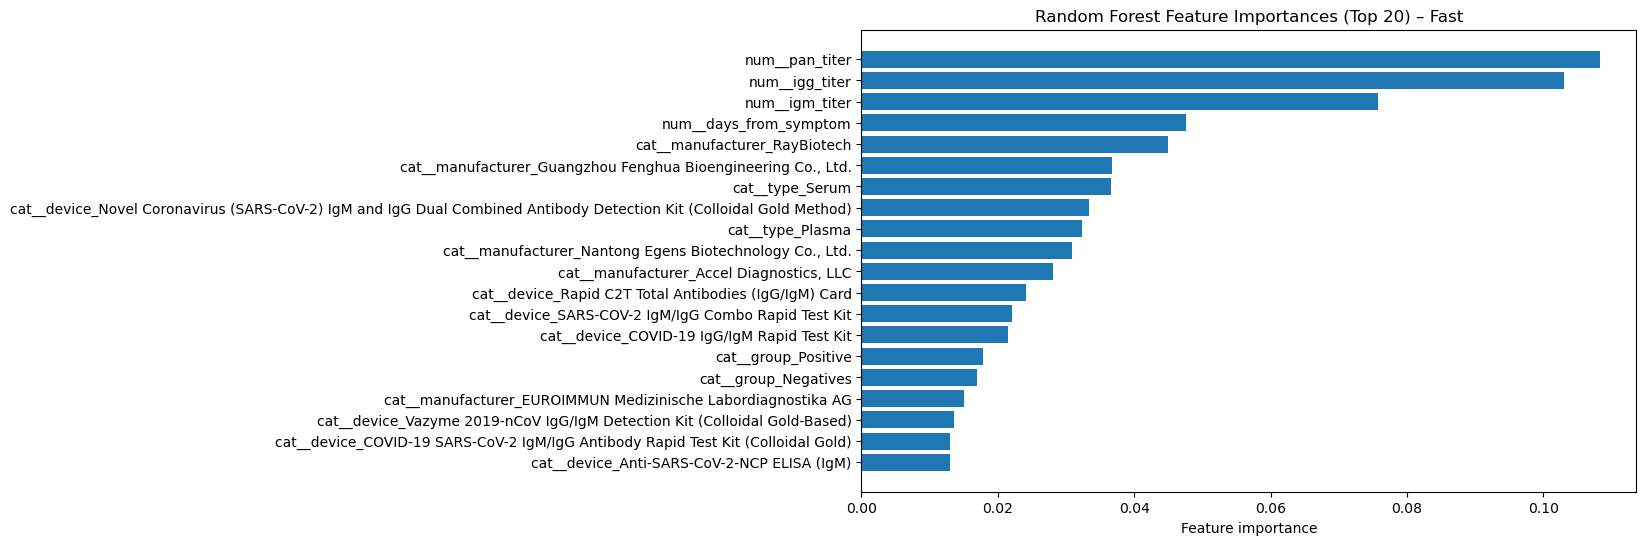

In [11]:

# Transform features and fit a standalone RF on transformed matrix for aligned importances
pre.fit(X_train)
try:
    feat_names_rf = pre.get_feature_names_out()
except Exception:
    feat_names_rf = np.array([f"f{i}" for i in range(pre.transform(X_train).shape[1])])

X_train_trans = pre.transform(X_train)
rf_fast = RandomForestClassifier(
    n_estimators=80, max_depth=10, n_jobs=-1, class_weight="balanced_subsample", random_state=42
).fit(X_train_trans, y_train)

imp = rf_fast.feature_importances_
imp_idx = np.argsort(imp)[::-1][:20]

plt.figure(figsize=(10,6))
ypos = np.arange(len(imp_idx))
plt.barh(ypos, imp[imp_idx])
plt.yticks(ypos, feat_names_rf[imp_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Random Forest Feature Importances (Top 20) – Fast")
plt.savefig(OUT_DIR / "rf_feature_importances_fast.png", bbox_inches="tight")
plt.show()
